<a href="https://www.kaggle.com/code/vanpatangan/predict-future-sales?scriptVersionId=195400199" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# import libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

# load data

In [2]:
sales_train = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
item_categories = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
test_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')

# data summary

In [3]:
def check(df):
    """
    Generates a concise summary of DataFrame columns.
    """
    # Compute values that are constant across columns
    total_rows = len(df)
    duplicates = df.duplicated().sum()

    # Use vectorized operations 
    dtypes = df.dtypes
    instances = df.count()
    unique = df.nunique()
    sum_null = df.isnull().sum()

    # Create the summary 
    df_check = pd.DataFrame({
        'column': df.columns,
        'dtype': dtypes,
        'instances': instances,
        'unique': unique,
        'sum_null': sum_null,
        'duplicates': duplicates  
    })

    return df_check

print("Sales Train")
display(check(sales_train))
display(sales_train.head())

print("Items")
display(check(items))
display(items.head())

print("Item Categories")
display(check(item_categories))
display(item_categories.head())

print("Shops")
display(check(shops))
display(shops.head())

print("Test")
display(check(test_df))
display(test_df.head())

Sales Train


,column,dtype,instances,unique,sum_null,duplicates
date,date,object,2935849,1034,0,6
date_block_num,date_block_num,int64,2935849,34,0,6
shop_id,shop_id,int64,2935849,60,0,6
item_id,item_id,int64,2935849,21807,0,6
item_price,item_price,float64,2935849,19993,0,6
item_cnt_day,item_cnt_day,float64,2935849,198,0,6


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.00
1,03.01.2013,0,25,2552,899.00,1.00
2,05.01.2013,0,25,2552,899.00,-1.00
3,06.01.2013,0,25,2554,1709.05,1.00
4,15.01.2013,0,25,2555,1099.00,1.00


Items


,column,dtype,instances,unique,sum_null,duplicates
item_name,item_name,object,22170,22170,0,0
item_id,item_id,int64,22170,22170,0,0
item_category_id,item_category_id,int64,22170,84,0,0


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


Item Categories


,column,dtype,instances,unique,sum_null,duplicates
item_category_name,item_category_name,object,84,84,0,0
item_category_id,item_category_id,int64,84,84,0,0


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


Shops


,column,dtype,instances,unique,sum_null,duplicates
shop_name,shop_name,object,60,60,0,0
shop_id,shop_id,int64,60,60,0,0


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


Test


,column,dtype,instances,unique,sum_null,duplicates
ID,ID,int64,214200,214200,0,0
shop_id,shop_id,int64,214200,42,0,0
item_id,item_id,int64,214200,5100,0,0


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


# merge

In [4]:
# Function to merge dataframes and reset index
def merge_dataframes(base_df, shops_df, items_df, item_categories_df):
    merged_df = pd.merge(base_df, shops_df, on='shop_id', how='left')
    merged_df = pd.merge(merged_df, items_df, on='item_id', how='left')
    merged_df = pd.merge(merged_df, item_categories_df, on='item_category_id', how='left')
    
    merged_df.reset_index(drop=True, inplace=True)
    
    # Dropping any duplicated rows
    merged_df.drop_duplicates(inplace=True)
    
    return merged_df

# Merge sales_train_df with the relevant dataframes and add identifier
train_df = merge_dataframes(sales_train, shops, items, item_categories)

# Merge test_df with the relevant dataframes and add identifier
test_df = merge_dataframes(test_df, shops, items, item_categories)

In [5]:
# Convert date column to datetime 
train_df['date'] = pd.to_datetime(train_df['date'], dayfirst=True)
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month_name()
train_df['weekday'] = train_df['date'].dt.day_name()

# visualization

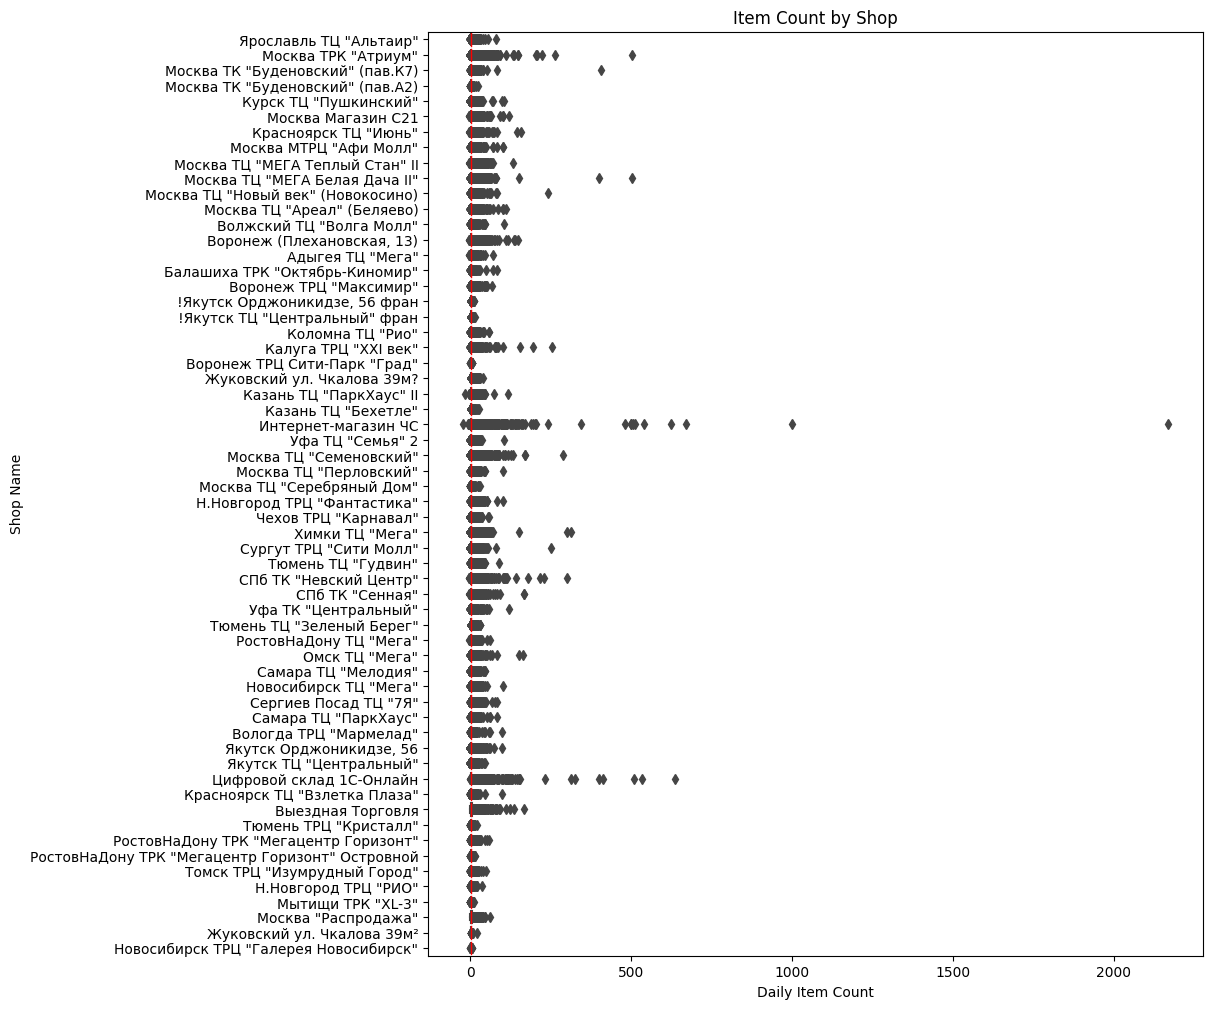

In [6]:
# Item count by shop
plt.figure(figsize=(10, 12))
sns.boxplot(y='shop_name', x='item_cnt_day', data=train_df, orient='h',
           medianprops={"color": "r", "linewidth": 1})
plt.title('Item Count by Shop')
plt.xlabel('Daily Item Count')
plt.ylabel('Shop Name')
plt.show()

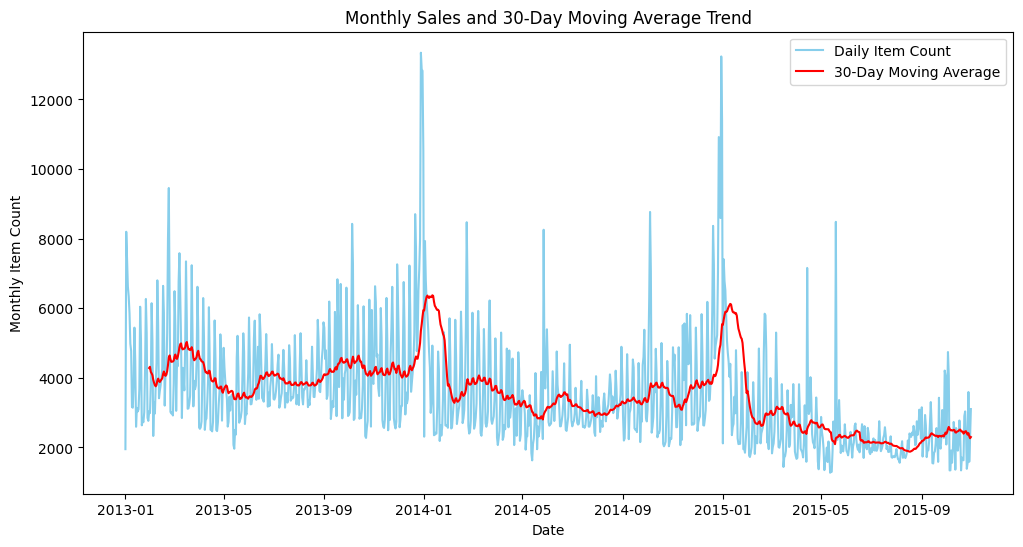

In [7]:
# Calculate daily sales
daily_sales = train_df.groupby('date')['item_cnt_day'].sum()

# Calculate 30-day moving average
moving_avg = daily_sales.rolling(window=30).mean()

# Plotting
plt.figure(figsize=(12, 6))

# Plot daily sales
plt.plot(daily_sales.index, daily_sales, label='Daily Item Count', color='skyblue')

# Plot moving average
plt.plot(moving_avg.index, moving_avg, label='30-Day Moving Average', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Monthly Item Count')
plt.title('Monthly Sales and 30-Day Moving Average Trend')
plt.legend()

# Display plot
plt.grid(False)
plt.show()

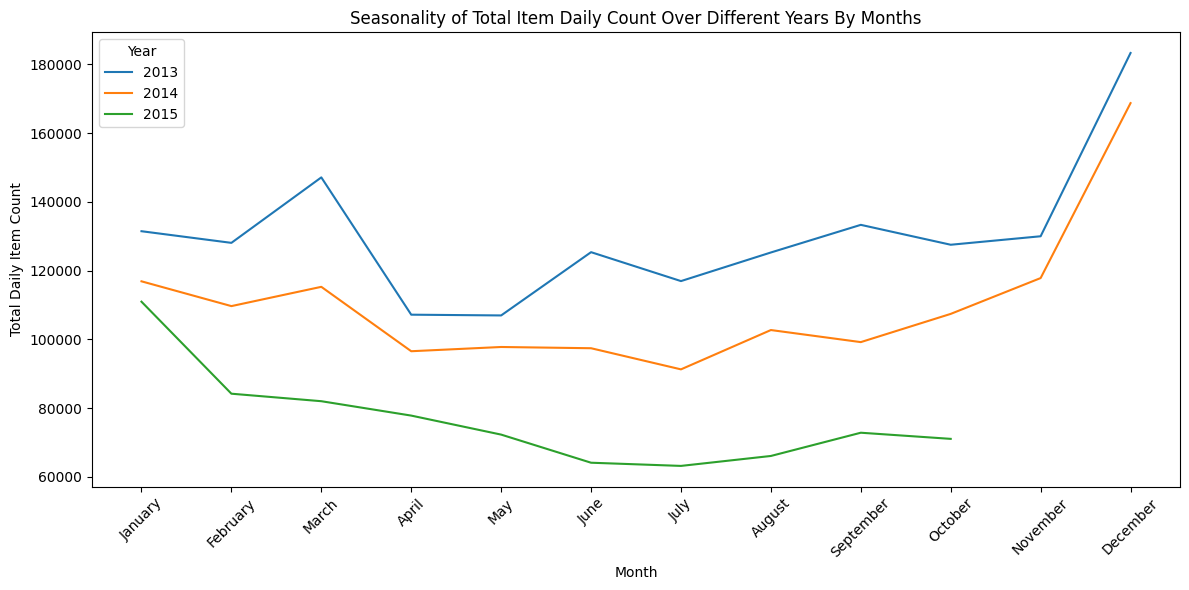

In [8]:
# Define the desired order of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Group by year and month, then calculate total sales
total_sales_year_month = train_df.groupby(['year', 'month'])['item_cnt_day'].sum().unstack(level=0).reindex(month_order)

# Plot the seasonality of sales
plt.figure(figsize=(12, 6))
sns.lineplot(data=total_sales_year_month, dashes=False)
plt.title('Seasonality of Total Item Daily Count Over Different Years By Months')
plt.xlabel('Month')
plt.ylabel('Total Daily Item Count')
plt.legend(title='Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

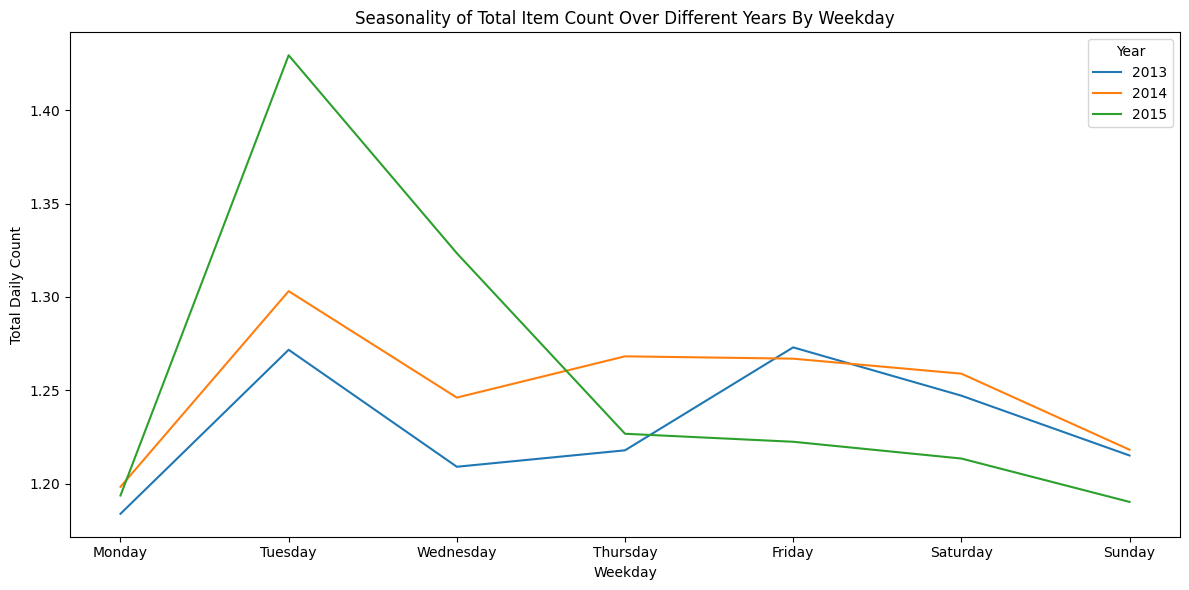

In [9]:
# Reorder weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group by year and weekday, then calculate total sales
sales_year_weekday = train_df.groupby(['year', 'weekday'])['item_cnt_day'].mean().unstack(level=0).reindex(weekday_order)

# Plot the seasonality of sales
plt.figure(figsize=(12, 6))
sns.lineplot(data=sales_year_weekday, dashes=False) 
plt.title('Seasonality of Total Item Count Over Different Years By Weekday')
plt.xlabel('Weekday')
plt.ylabel('Total Daily Count')
plt.legend(title='Year')
plt.tight_layout()
plt.show()

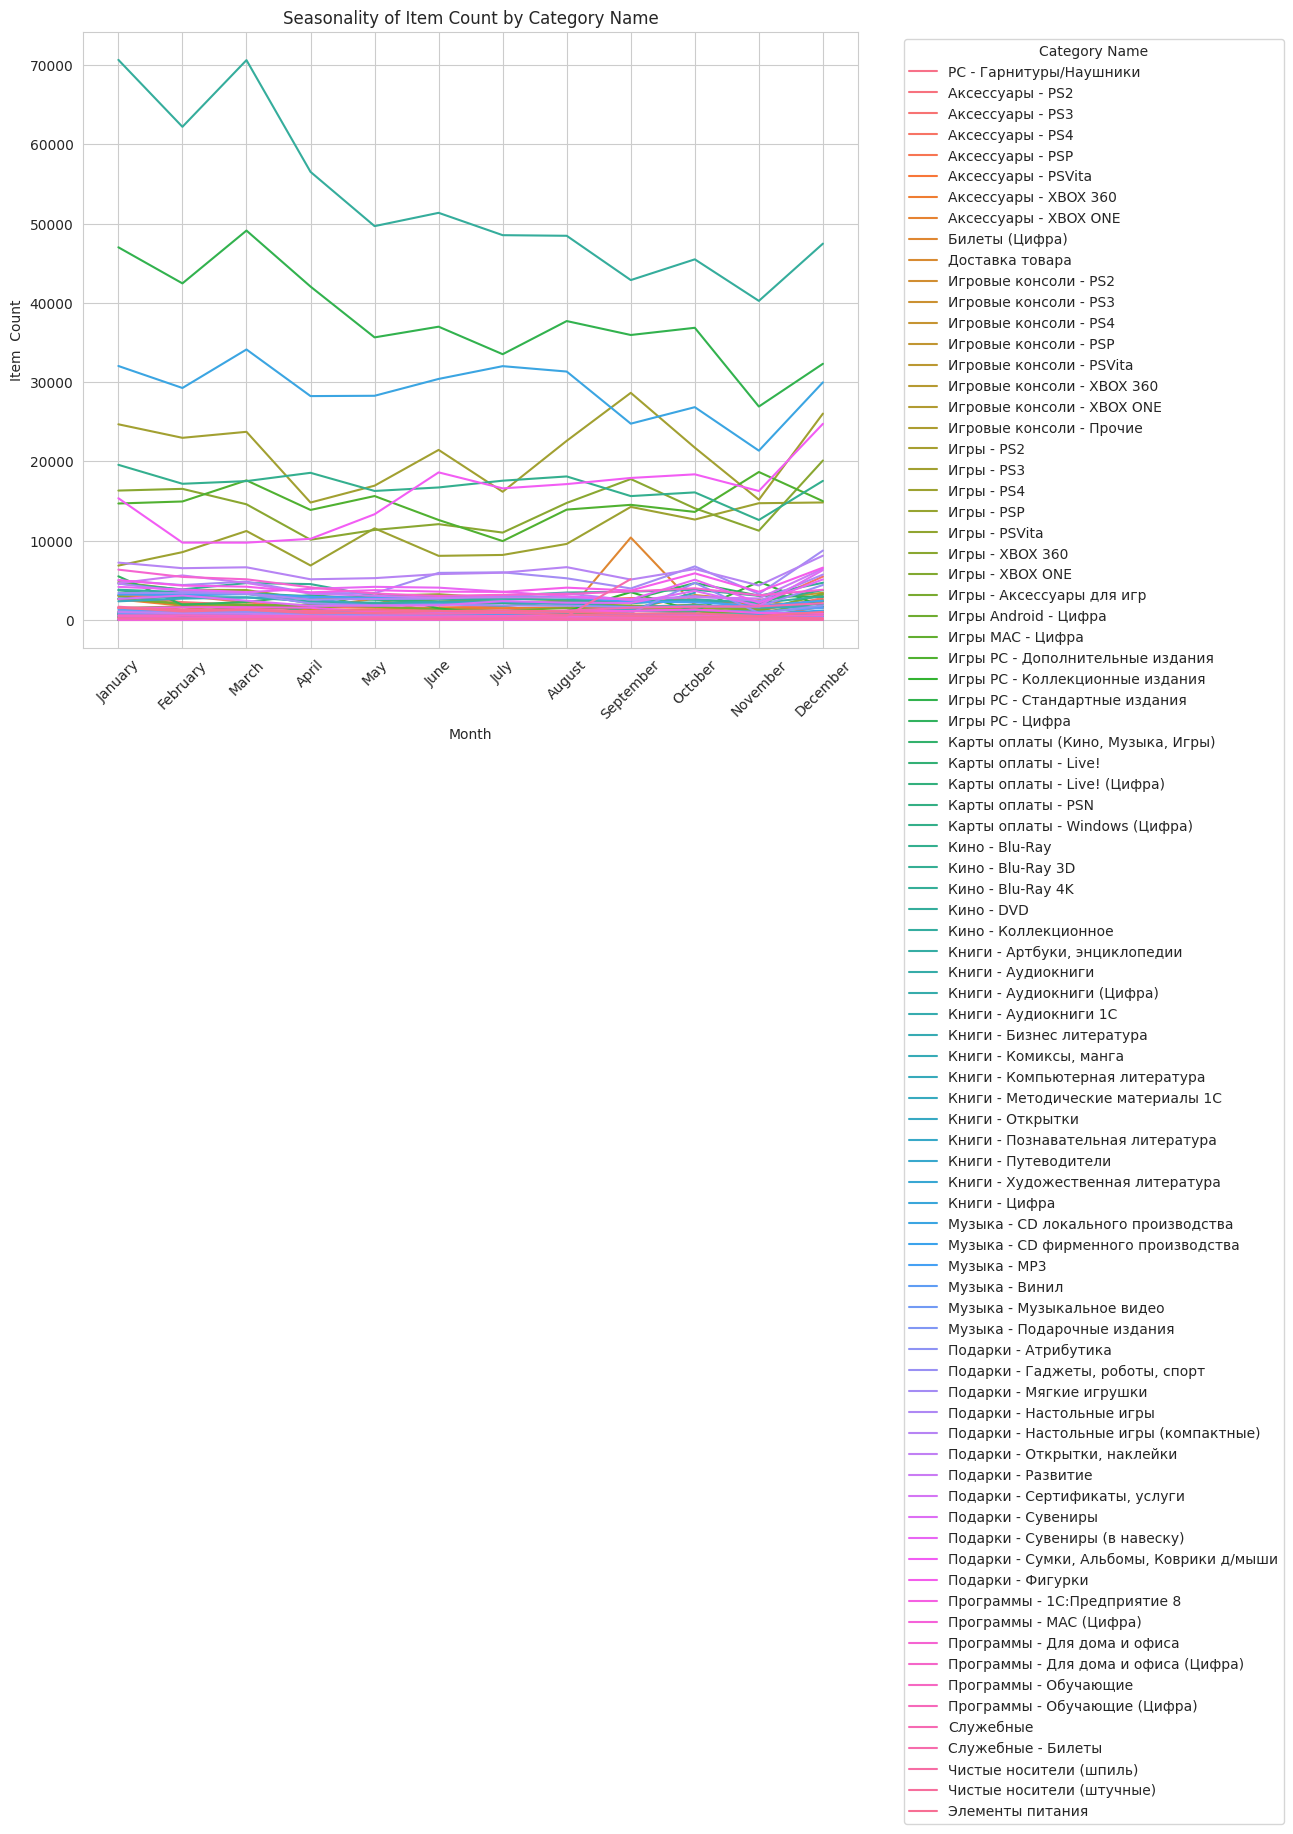

In [10]:
# Define the desired order of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Group by family and month and calculate mean sales
seasonality_data = train_df.groupby(['item_category_name', 'month'])['item_cnt_day'].sum().unstack(level=0).reindex(month_order)

# Visualize seasonality using line plots for each family and store type
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
sns.lineplot(data=seasonality_data, dashes=False)
plt.title('Seasonality of Item Count by Category Name')
plt.xlabel('Month')
plt.ylabel('Item  Count')
plt.xticks(rotation=45)
plt.legend(title='Category Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# handle negative values

In [11]:
# Identify numeric columns
numeric_columns = train_df.select_dtypes(include=[float, int]).columns.tolist()

# Identify numeric columns with negative values
negative_columns = [col for col in numeric_columns if (train_df[col] < 0).any()]

# Calculate the median of positive values for each column with negative values
median_positive_values = {
    column: train_df[train_df[column] > 0][column].median() for column in negative_columns
}

# Replace negative values in each column with the corresponding median of positive values
for column, median in median_positive_values.items():
    train_df.loc[train_df[column] < 0, column] = median

# handle outliers

In [12]:
# Identify outliers
def identify_outliers(df, threshold=3):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    outliers = {}
    for col in numeric_cols:
        mean = df[col].mean()
        std = df[col].std()
        z_scores = (df[col] - mean) / std
        outliers[col] = df[np.abs(z_scores) > threshold]
    return outliers

# Call function
outlier_results = identify_outliers(train_df)

In [13]:
# Replace outliers with median
def replace_outliers_with_median(df, threshold=3):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in numeric_cols:
        mean = df[col].mean()
        std = df[col].std()
        median = df[col].median()
        z_scores = (df[col] - mean) / std
        df[col][np.abs(z_scores) > threshold] = median
    return df

train_df_cleaned = replace_outliers_with_median(train_df)

# time features

In [14]:
def create_features(df, is_train=True):
    if 'item_price' in df.columns:
        # Creating price per item feature
        df['price_per_item'] = df['item_price'] / df['item_cnt_day'] if 'item_cnt_day' in df else 0
        
        # Groupby operations
        group = df.groupby('item_id')['item_price']
        historical_min_price = group.transform('min')
        first_selling_month = df.groupby('item_id')['date_block_num'].transform('min')
        
        # Creating price difference from the current price - the historical min item price
        df['historical_min_price'] = historical_min_price
        df['price_diff_min'] = df['item_price'] - historical_min_price
        
        # Creating first selling month of a product
        df['first_selling_month'] = first_selling_month
        
        # Boolean to check if a product is newly launched product at that instance
        df['is_new_product'] = (df['date_block_num'] == first_selling_month).astype(int)
        
        # Creating rolling window features
        df['item_price_roll_mean_3'] = group.transform(lambda x: x.rolling(window=3, min_periods=1).mean()).fillna(0)
        df['item_price_roll_mean_6'] = group.transform(lambda x: x.rolling(window=6, min_periods=1).mean()).fillna(0)
        df['item_price_roll_std_3'] = group.transform(lambda x: x.rolling(window=3, min_periods=1).std()).fillna(0)
        df['item_price_roll_std_6'] = group.transform(lambda x: x.rolling(window=6, min_periods=1).std()).fillna(0)
        
        # Creating min and max price of that product
        df['min_item_price'] = historical_min_price
        df['max_item_price'] = group.transform('max')
    else:
        # If 'item_price' column does not exist, create default or dummy columns
        df[['price_per_item', 'historical_min_price', 'price_diff_min', 'first_selling_month', 
            'is_new_product', 'item_price_roll_mean_3', 'item_price_roll_mean_6', 
            'item_price_roll_std_3', 'item_price_roll_std_6', 'min_item_price', 'max_item_price']] = 0
    
    if is_train:
        # Creating lag features
        lags = [1, 2, 3, 6, 12]
        for lag in lags:
            df[f'item_cnt_day_lag_{lag}'] = df.groupby('item_id')['item_cnt_day'].shift(lag).fillna(0)
        
        # Creating trend features
        df['item_cnt_day_diff'] = df.groupby('item_id')['item_cnt_day'].diff().fillna(0)
        df['item_cnt_day_pct_change'] = df.groupby('item_id')['item_cnt_day'].pct_change().fillna(0)
    
    return df

# Apply feature creation to train set
train_df = create_features(train_df)

In [15]:
# Creating historical lag features for test set from train set
def create_test_features(train_df, test_df):
    test_df = test_df.copy()
    
    # Calculate historical lags based on training data
    lags = [1, 2, 3, 6, 12]
    for lag in lags:
        lag_col = f'item_cnt_day_lag_{lag}'
        test_df[lag_col] = test_df['item_id'].map(train_df.groupby('item_id')['item_cnt_day'].shift(lag).fillna(0).to_dict())
    
    # Trend features
    test_df['item_cnt_day_diff'] = test_df['item_id'].map(train_df.groupby('item_id')['item_cnt_day'].diff().fillna(0).to_dict())
    test_df['item_cnt_day_pct_change'] = test_df['item_id'].map(train_df.groupby('item_id')['item_cnt_day'].pct_change().fillna(0).to_dict())
    
    return test_df

# Apply feature creation to test set
test_df = create_features(test_df, is_train=False)
test_df = create_test_features(train_df, test_df)

In [16]:
# Copy Id for submission
test_id = test_df['ID'].copy()

# Identify columns present in train_df but not in test_df 
missing_columns = set(train_df.columns) - set(test_df.columns) - {'item_cnt_day'}

# Add missing columns to test_df with default values 0
for col in missing_columns:
    test_df[col] = 0  

# Ensure both dataframes have the same column order 
common_columns = [col for col in train_df.columns if col in test_df.columns and col != 'item_cnt_day']

# Reorder columns
train_df = train_df[common_columns + ['item_cnt_day']]
test_df = test_df[common_columns]

# Verify that the columns are aligned 
assert set(train_df.columns) == set(test_df.columns).union({'item_cnt_day'}), "Columns do not match"

In [17]:
from sklearn.preprocessing import LabelEncoder

# Label encode object dtype columns
le = LabelEncoder()
object_cols = train_df.select_dtypes(include='object').columns
for col in object_cols:
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.fit_transform(test_df[col])

# modeling

In [18]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

# Define the feature set and target variable
X = train_df.drop(['item_cnt_day', 'date'], axis=1)
y = train_df['item_cnt_day']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  random_state=42)
# Define parameter grid for hyperparameter tuning
param_grid = {
    'num_leaves': [31],
    'learning_rate': [0.05],
    'feature_fraction': [0.9],
    'bagging_fraction': [0.8],
    'bagging_freq': [5],
    'verbose': [-1]
}

# Initialize LightGBM regressor
lgb_estimator = lgb.LGBMRegressor(objective="regression", metric="rmse", seed=1)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, 
                           cv=3, scoring='neg_root_mean_squared_error', verbose=-1, 
                           n_jobs=-1)

# Fit the Grid Search
grid_search.fit(X_train, y_train)

# Best parameters from Grid Search
best_params = grid_search.best_params_
print("Best parameters found by Grid Search:", best_params)

# Train the final model with the best parameters
final_model = lgb.LGBMRegressor(**best_params, objective="regression", metric="rmse", seed=1)
final_model.fit(X_train, y_train)

# Predict on the validation set
y_pred = final_model.predict(X_val)

# Evaluate the final model
mse_final = mean_squared_error(y_val, y_pred)
rmse_final = np.sqrt(mse_final)
r2_final = r2_score(y_val, y_pred)

print("Final Model RMSE:", rmse_final)
print("Final Model R-squared:", r2_final)

Best parameters found by Grid Search: {'bagging_fraction': 0.8, 'bagging_freq': 5, 'feature_fraction': 0.9, 'learning_rate': 0.05, 'num_leaves': 31, 'verbose': -1}
Final Model RMSE: 0.02995409304736896
Final Model R-squared: 0.9978730760286305


# predict on test set

In [19]:
# Drop date
X_test = test_df.drop(['date'], axis=1)

# Check the test set has the same columns as the training set
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X_train.columns]

# Predict on the test dataset
y_test_pred = final_model.predict(X_test)

# submission

In [20]:
# Save the predictions
predictions_df = pd.DataFrame({'id': test_id, 'item_cnt_month': y_test_pred})

# Save predictions to a CSV file
predictions_df.to_csv('submission.csv', index=False)

# Display the first few rows of the predictions
predictions_df.head()

,id,item_cnt_month
0,0,1.96
1,1,1.95
2,2,3.04
3,3,1.27
4,4,1.96
